## **Problem Statement**

## Goal
The goal is to analyze Walmart's weekly sales data to:
- Identify key factors influencing sales.
- Understand the impact of holidays and temperature.
- Build a predictive model for future sales.
- Optimize inventory, staffing, and marketing strategies based on insights.

## Questions
1. What are the key factors that influence Walmart's weekly sales?  
2. How do holidays and temperature impact weekly sales?  
3. Are there any seasonal trends or patterns in the sales data?  
4. How do external factors like CPI, unemployment, and fuel prices affect sales?  
5. Can we build a machine learning model to predict weekly sales based on the given features?  
6. How do sales vary during **Thanksgiving**, **Black Friday**, and **Christmas** weeks compared to non-festive 


**-----------------------------------------------------------------------------------------------------**

### **Importing Libraries**

Grouping all the necessary imports at the beginning of the notebook. This is a best practice to ensure all dependencies are loaded before running any analysis

In [92]:
# Importing Libraries
import pandas as pd
import numpy as np

# For Plots Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For Stats Analysis
import scipy.stats as stats
from scipy.stats import ttest_ind, t
import statsmodels.api as sm
from scipy.stats import shapiro


# For ML Model Train-Test and Evalute
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# For Ignoring Warning
import warnings

### **Ignoring Warning**
To avoid cluttering the output with warnings, we’ll suppress them using Python’s warnings module.

In [93]:
warnings.filterwarnings('ignore')

### **Exception Handling & Importing Dataset**
 Implementing exception handling to catch and manage errors efficiently.<br>
 This improves debugging and ensures smooth execution, even when unexpected issues arise.


In [94]:
try:
    walmart = pd.read_csv('walmart-sales-dataset-of-45stores.csv')
    print("Dataset loaded successfully!!")
except Exception as e:
    print(f"Error loading dataset: {e}")

Dataset loaded successfully!!


**-----------------------------------------------------------------------------------------------------**

## **Exploratory Data Analysis (EDA)**

### **Basic Information about the Dataset**<br>
( i ): Dataset information to check data types and missing values

In [95]:
walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


( ii ): Transposing the first few rows using **.head().T** for better readability.<br> Helps in quickly inspecting feature names and their values.

In [96]:
walmart.head().T

,0,1,2,3,4
Store,1,1,1,1,1
Date,05-02-2010,12-02-2010,19-02-2010,26-02-2010,05-03-2010
Weekly_Sales,1643690.9,1641957.44,1611968.17,1409727.59,1554806.68
Holiday_Flag,0,1,0,0,0
Temperature,42.31,38.51,39.93,46.63,46.5
Fuel_Price,2.572,2.548,2.514,2.561,2.625
CPI,211.096358,211.24217,211.289143,211.319643,211.350143
Unemployment,8.106,8.106,8.106,8.106,8.106


( iii ): Using **.describe()** to get summary statistics of numerical features. <br>

In [97]:
walmart.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


#### ( iv ): **Checking the lenght of the dataset**<br>
Total Rows: 6435<br>
Total Columns: 8<br>


In [98]:
walmart.shape

(6435, 8)

#### ( v ): Counting **missing values** in each column <br>
There are no null values in the dataset. 

In [99]:
walmart.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

#### ( vi ): Checking for **duplicates rows**
There is no duplicate in the dataset

In [100]:
walmart.duplicated().sum()

np.int64(0)

#### ( vii ): Checking how many **unique values** exist per Columns 
`1. Weekly_Sales (6435 unique values)` – can be used as a target variable for prediction.<br>
`2. Date (143 unique values)` – we will use this for time series analysis and seasonal trends.<br>
`3. Temperature (3528 unique values)` – we Can see if Temperature impact sales patterns (e.g., winter vs. summer demand).<br>
`4. Fuel_Price (892 unique values)` – May affect consumer spending behavior.<br>
`5. CPI (2145 unique values)` – Measures inflation, which could impact sales trends.<br>
`6. Unemployment (349 unique values)` – Economic indicator affecting consumer purchasing power.<br>

In [101]:
walmart.nunique()

Store             45
Date             143
Weekly_Sales    6435
Holiday_Flag       2
Temperature     3528
Fuel_Price       892
CPI             2145
Unemployment     349
dtype: int64

**-----------------------------------------------------------------------------------------------------**

## **Featuring Engineering**

#### Handling Date Format Issues
-The Date column may have inconsistent formats, leading to errors during conversion.<br>
-We use `dayfirst=True` to correctly interpret dates in "DD-MM-YYYY" format.<br>
-The `errors='coerce'` parameter ensures invalid dates are converted to NaT (missing values).<br>
-We drop any rows where the Date conversion failed to maintain data integrity which will not create trouble in further analysis and ploting.

In [102]:
try:
    # converting date into datetime
    walmart['Date'] = pd.to_datetime(walmart['Date'], dayfirst=True, errors='coerce')
    
    # droping the rows where conversion failed
    walmart = walmart.dropna(subset=['Date'])
    print("Date Column is succesfully converted into datetime format")
    
except Exception as e:
    print(f"Error processing time-based features: {e}")

Date Column is succesfully converted into datetime format


#### Extracting Time-Based Features
-This part extracts features like `Year`, `Month`, `Week`, and `DayOfWeek` from the Date column.<br>
-Extracting time-based features helps capture temporal patterns in the data, such as seasonality, trends, and weekly cycles.<br>

In [103]:
try:
    # Extract time-based features
    walmart['Year'] = walmart['Date'].dt.year
    walmart['Month'] = walmart['Date'].dt.month
    walmart['Week'] = walmart['Date'].dt.isocalendar().week
    walmart['DayOfWeek'] = walmart['Date'].dt.dayofweek
    
    print("Time-based features extracted successfully!")
    
except KeyError as e:
    print(f"KeyError: {e} Ensure the 'Date' column exists in the DataFrame.")
except AttributeError as e:
    print(f"AttributeError: {e} Ensure the 'Date' column is in datetime format.")
except Exception as e:
    print(f"Unexpected error while extracting time-based features: {e}")

Time-based features extracted successfully!


#### Creating a Holiday Season Flag
-This part creates a binary flag `(Holiday_Season) `to indicate whether a date falls in November or December. <br>
-The holiday season (November and December) often has unique sales patterns due to holidays like Thanksgiving and Christmas.<br>
-This flag helps the analysis account for these seasonal effects.

In [104]:
try:
    # Create a Holiday Season flag (for November and December)
    walmart['Holiday_Season'] = walmart['Month'].apply(lambda x: 1 if x in [11, 12] else 0)
    
    print("Holiday Season flag created successfully!")
    
except KeyError as e:
    print(f"KeyError: {e} - Ensure the 'Month' column exists in the DataFrame.")
except Exception as e:
    print(f"Unexpected error while creating Holiday Season flag: {e}")

Holiday Season flag created successfully!


#### Creating a Lag Feature
-This part creates a lag feature `(Prev_Week_Sales)` to include the previous week’s sales as a feature.<br>
-Lag features are useful for time-series analysis and machine learning models to capture dependencies on past values.<br>
-For example, sales in the current week might be influenced by sales in the previous week.

In [105]:
try:
    # Creating lag feature for previous week's sales
    walmart['Prev_Week_Sales'] = walmart['Weekly_Sales'].shift(1)
    
    # Handle missing values in lag feature (first row will be NaN)
    walmart['Prev_Week_Sales'] = walmart['Prev_Week_Sales'].fillna(0)
    
    print("Lag feature created successfully!")
    
except KeyError as e:
    print(f"KeyError: {e} - Ensure the 'Weekly_Sales' column exists in the DataFrame.")
except Exception as e:
    print(f"Unexpected error while creating lag feature: {e}")

Lag feature created successfully!


#### Creating Temperature bins
-We’ll create temperature bins to categorize the temperature into different ranges (e.g., cold, moderate, hot). <br>
-This will help us analyze how sales vary across different temperature conditions.

`Cold:` Temperature ≤ 40°F<br>
`Moderate:` 40°F < Temperature ≤ 70°F<br>
`Hot:` Temperature > 70°F<br>

In [106]:
# Creating the  temperature bins
walmart['Temperature_Bin'] = pd.cut(walmart['Temperature'], bins=[-np.inf, 40, 70, np.inf], labels=['Cold', 'Moderate', 'Hot'])

# Checking distribution of temperature bins
print(walmart['Temperature_Bin'].value_counts())

Temperature_Bin
Moderate    3174
Hot         2272
Cold         989
Name: count, dtype: int64


#### Applying Festive Week Flags

Identifying whether specific dates in the walmart dataset fall within `Thanksgiving, Black Friday, or Christmas weeks`. <br>
Functions check the date range for each `festive week` and `return 1 (yes) or 0 (no)`. <br>
These flags are then added as new columns to the dataset, enabling holiday-based sales analysis

In [107]:
# Defining festive dates
thanksgiving_dates = ['2010-11-25', '2011-11-24', '2012-11-22']
black_friday_dates = ['2010-11-26', '2011-11-25', '2012-11-23']

# Function to check if a date belongs to a festive week
def is_festive_week(date):
    if date in pd.to_datetime(thanksgiving_dates):
        return 'Thanksgiving'
    elif date in pd.to_datetime(black_friday_dates):
        return 'Black Friday'
    elif date.month == 12 and 18 <= date.day <= 24:
        return 'Christmas'
    return None

# Applying function
walmart['Festive_Week'] = walmart['Date'].apply(is_festive_week)

# Creating separate flags
walmart['Thanksgiving_Week'] = (walmart['Festive_Week'] == 'Thanksgiving').astype(int)
walmart['Black_Friday_Week'] = (walmart['Festive_Week'] == 'Black Friday').astype(int)
walmart['Christmas_Week'] = (walmart['Festive_Week'] == 'Christmas').astype(int)


**-----------------------------------------------------------------------------------------------------**

## **Visualization**

### ***Store-wise Sales Analysis***
The bar chart illustrates the `top 10 stores` by `average weekly sales.`

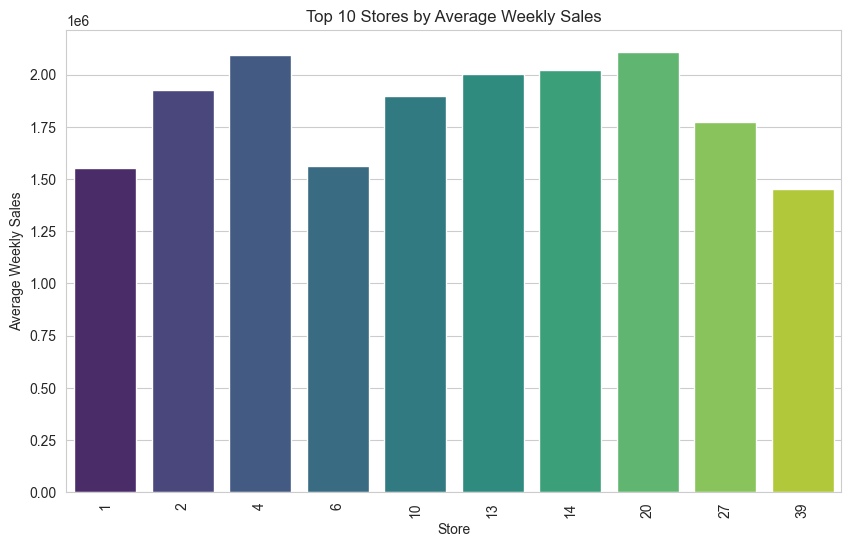

In [108]:
# Calculating the average weekly sales per store and sorting in descending order
top_stores = walmart.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_stores.index, y=top_stores.values, estimator=np.mean, ci=None, palette='viridis')

plt.xlabel('Store')
plt.ylabel('Average Weekly Sales')
plt.title('Top 10 Stores by Average Weekly Sales')

plt.xticks(rotation=90)

plt.show()


#### **Insights:**

**Top Performer:** Store 4 leads with nearly 2.0 million average weekly sales, likely due to effective strategies.

**Comparison:** Other top 10 stores have sales ranging from 1.5 to just under 2.0 million, indicating strong but slightly lower performance.

**Strategic** Focus: Use insights from the top store to improve others.

**Store 39:** Despite being lower in the top 10, Store 39 has substantial sales but could benefit from adopting top stores' strategies.

**-----------------------------------------------------------------------------------------------------**

### ***Distribution of Weekly Sales***
We are plotting a histogram of the `Weekly_Sales` column to visualize its distribution

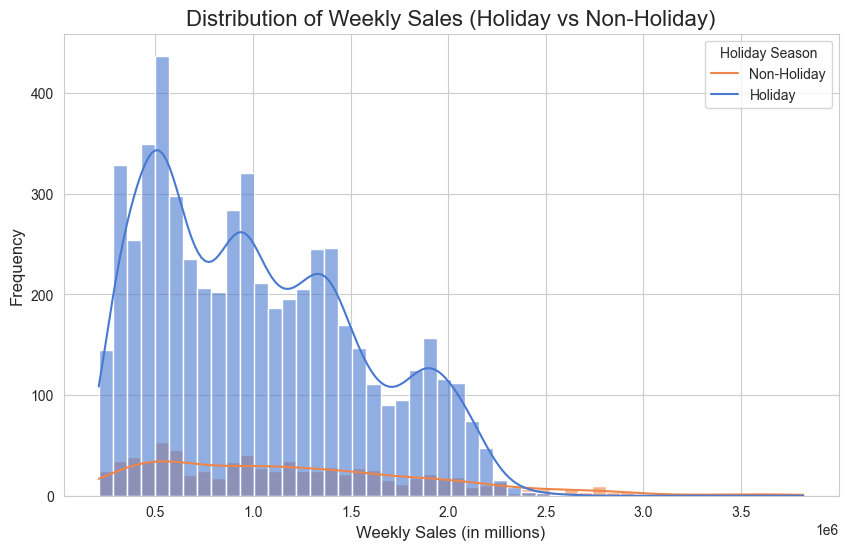

In [109]:
try:
    # Distribution of Weekly_Sales
    plt.figure(figsize=(10, 6))
    sns.histplot(data=walmart, x='Weekly_Sales', bins=50, kde=True, hue='Holiday_Season', palette='muted', alpha=0.6)
    plt.title('Distribution of Weekly Sales (Holiday vs Non-Holiday)', fontsize=16)
    plt.xlabel('Weekly Sales (in millions)', fontsize=12)  
    plt.ylabel('Frequency', fontsize=12)
    plt.legend(title='Holiday Season', labels=['Non-Holiday', 'Holiday'])
    plt.show()
    
except KeyError as e:
    print(f"KeyError: {e} Ensure the 'Weekly_Sales' and 'Holiday_Season' columns exist in the DataFrame.")
except TypeError as e:
    print(f"TypeError: {e} Ensure the 'Weekly_Sales' column contains numeric data.")
except Exception as e:
    print(f"Unexpected error while plotting distribution of Weekly Sales: {e}")

#### **Insights:**

#### **Holiday Season Sales:**<br>
- The distribution of holiday season sales shows a higher frequency of sales in the range of 0.5 to 1.5 million.<br>
- There are noticeable peaks around 0.5 million, 1.0 million, and 1.5 million, indicating that these sales figures are more common during the holiday season.<br>
- The frequency decreases as the sales amount increases beyond 1.5 million.<br>

#### **Non-Holiday Season Sales:**<br>

- The non-holiday season sales have a much lower frequency compared to the holiday season.
- he orange line remains relatively flat, indicating that high sales figures are less common during non-holiday periods.
- There is a slight increase in frequency around 0.5 million, but it is significantly lower than the holiday season sales.

**- The plot clearly shows that weekly sales are generally higher and more frequent during the holiday season compared to the non-holiday season.**<br>
**- This suggests that the holiday season has a significant impact on increasing weekly sales.**

**-----------------------------------------------------------------------------------------------------**

### ***Sales Trends Over Time***
Plotting a line plot of `Weekly_Sales over time (Date)`.<br>
The x-axis represents the date, ranging from early 2010 to late 2012, while the y-axis represents weekly sales in millions.

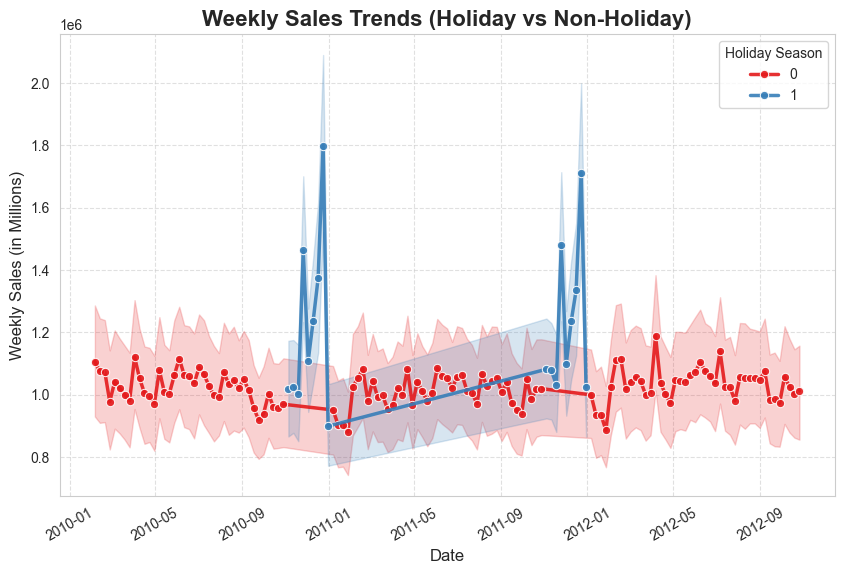

In [110]:
try:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=walmart, x='Date', y='Weekly_Sales', hue='Holiday_Season',palette='Set1', linewidth=2.5, marker="o", alpha=0.9)
    plt.title('Weekly Sales Trends (Holiday vs Non-Holiday)', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Weekly Sales (in Millions)', fontsize=12)
    
    plt.xticks(rotation=30)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Holiday Season', frameon=True)
    
    plt.show()
    
except KeyError as e:
    print(f"KeyError: {e} Ensure the 'Weekly_Sales' and 'Holiday_Season' columns exist in the DataFrame.")
except TypeError as e:
    print(f"TypeError: {e} Ensure the 'Weekly_Sales' column contains numeric data.")
except Exception as e:
    print(f"Unexpected error while plotting distribution of Weekly Sales: {e}") 
        


#### **Insights:**

#### **Holiday Season Sales:**

- The blue line represents holiday season sales.<br>
- Sales during holiday periods show significant spikes, indicating higher sales during holidays.<br>
- Sharp peaks are visible, suggesting that specific holiday events drive notable increases in sales.<br>

#### **Non-Holiday Season Sales:**

- The red line represents non-holiday season sales.<br>
- Non-holiday sales are relatively stable with minor fluctuations.<br>
- There are occasional increases, but they are not as pronounced as during the holiday periods.<br>

**- The plot clearly shows that sales are generally higher during the holiday season compared to non-holiday periods.**<br>
**- The confidence intervals (shaded areas) are wider during holiday periods, indicating greater variability in sales during these times.**<br>
**- Holidays have a positive impact on sales, with marked increases during these periods.**

**-----------------------------------------------------------------------------------------------------**

### ***Correlation Matrix***
The correlation matrix illustrates the relationships between different variables related to sales and economic indicators.

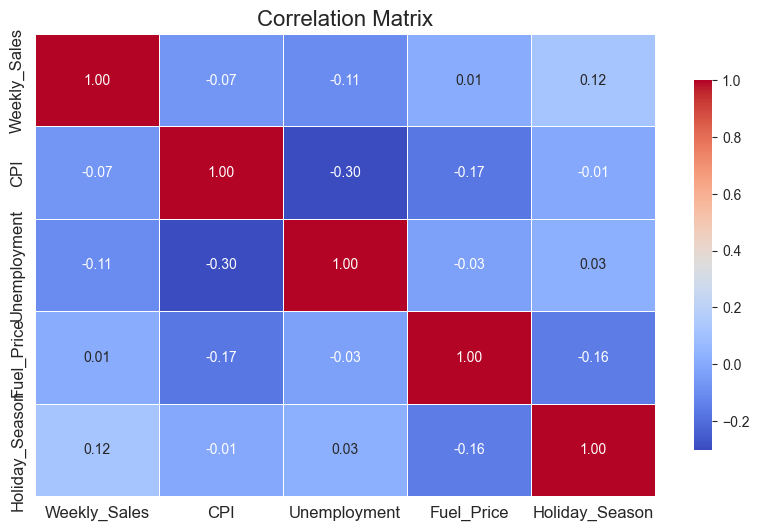

In [111]:
try:
    # Correlation matrix 
    plt.figure(figsize=(10, 6))
    corr = walmart[['Weekly_Sales', 'CPI', 'Unemployment', 'Fuel_Price', 'Holiday_Season']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
    plt.title('Correlation Matrix', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    
except KeyError as e:
    print(f"KeyError: {e} - Ensure all columns ('Weekly_Sales', 'CPI', 'Unemployment', 'Fuel_Price', 'Holiday_Season') exist in the DataFrame.")
except TypeError as e:
    print(f"TypeError: {e} - Ensure all columns contain numeric data.")
except Exception as e:
    print(f"Unexpected error while creating correlation matrix: {e}")

#### **Insights**
**- `Holiday seasons` have a good positive impact on weekly sales, but other economic indicators like `CPI` and `Unemployment` show weak correlations with sales**<br>

**- The relationship between `CPI` and `Unemployment` is the most notable, indicating that `higher unemployment` is associated with `lower CPI`.**<br>

**- `Fuel prices` have `minimal impact` on `sales`, `CPI`, and `unemployment`.**<br>

**-----------------------------------------------------------------------------------------------------**

### ***Impact of Temperature on Weekly Sales Distribution***

#### -Analyzing Sales Variability Across Cold, Moderate, and Hot Temperature Conditions



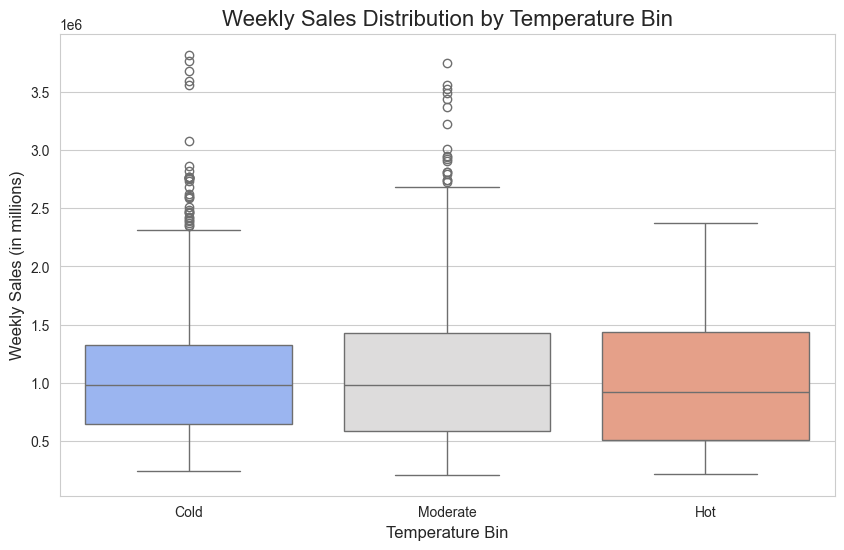

In [112]:
# Box plot of Weekly Sales by Temperature Bin
plt.figure(figsize=(10, 6))
sns.boxplot(data=walmart, x='Temperature_Bin', y='Weekly_Sales', palette='coolwarm')
plt.title('Weekly Sales Distribution by Temperature Bin', fontsize=16)
plt.xlabel('Temperature Bin', fontsize=12)
plt.ylabel('Weekly Sales (in millions)', fontsize=12)
plt.show()

#### **Insights**

`Cold Bin:` Median ~1 million; IQR 0.75-1.5 million; several outliers above 2.5 million.

`Moderate Bin:` Median slightly above 1 million; IQR 0.75-1.5 million; similar outliers as cold bin.

`Hot Bin:` Median ~1 million; IQR 0.75-1.5 million; fewer outliers, indicating more consistent sales.

Sales are relatively consistent across all temperature bins, with a median of around 1 million.<br>
There are more outliers in the cold and moderate bins, suggesting that extreme sales values are more common in these temperature ranges.

**-----------------------------------------------------------------------------------------------------**

#### ***Weekly Sales Trends with Festive Week Highlights***

- Objective: Visualizing weekly sales over time and highlighting key festive weeks (Thanksgiving, Black Friday, Christmas) to see their impact.
- Method: A line plot for overall sales trends, with scatter plots marking festive weeks in different colors for clarity.
- Insight: This helps identify seasonal spikes and trends during major holidays.

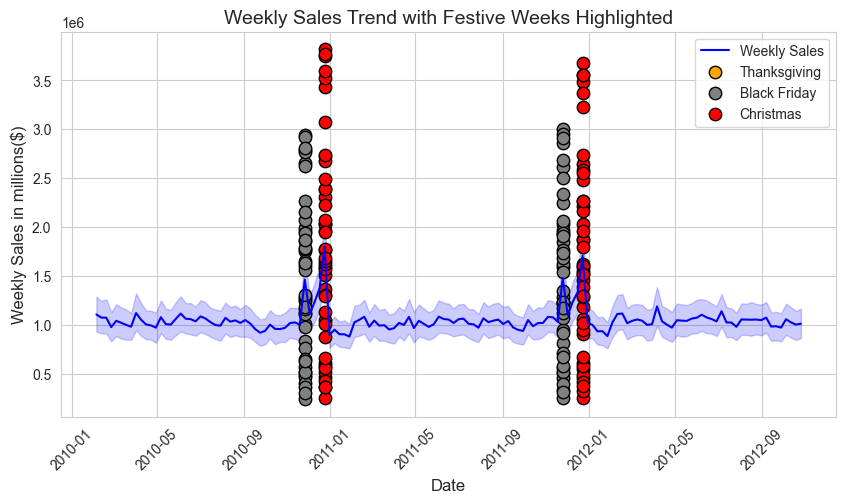

In [117]:
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

# Plot weekly sales trend
sns.lineplot(data=walmart, x='Date', y='Weekly_Sales', label='Weekly Sales', color='blue')

# Highlight festive weeks
plt.scatter(walmart[walmart['Thanksgiving_Week'] == 1]['Date'], 
            walmart[walmart['Thanksgiving_Week'] == 1]['Weekly_Sales'], 
            color='orange', label='Thanksgiving', s=80, edgecolors='black')

plt.scatter(walmart[walmart['Black_Friday_Week'] == 1]['Date'], 
            walmart[walmart['Black_Friday_Week'] == 1]['Weekly_Sales'], 
            color='grey', label='Black Friday', s=80, edgecolors='black')

plt.scatter(walmart[walmart['Christmas_Week'] == 1]['Date'], 
            walmart[walmart['Christmas_Week'] == 1]['Weekly_Sales'], 
            color='red', label='Christmas', s=80, edgecolors='black')


plt.title('Weekly Sales Trend with Festive Weeks Highlighted', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Weekly Sales in millions($)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.show()


### Festive Week Sales Insights

- Significant sales spikes during **Thanksgiving**, **Black Friday**, and **Christmas** weeks.
- **Christmas** records the highest sales surge, indicating peak consumer activity.
- Overall sales remain stable with variability during festive periods.
- Insights support **targeted marketing** and **inventory planning** for festive seasons.


**-----------------------------------------------------------------------------------------------------**

## **Statistical analysis**

***Checking Normality of Sales Data***

**Why?**<br>
Before performing any hypothesis tests or calculating confidence intervals, we need to check if the weekly sales data is normally distributed.
If the data is not normally distributed, we may need to transform it (e.g., log transformation) or use non-parametric tests.

If the data is normally distributed, we can proceed with parametric tests like the t-test.

Analysis Name:
Normality Check using `Shapiro-Wilk Test` and `Visualizations (Histogram and Q-Q Plot)`.

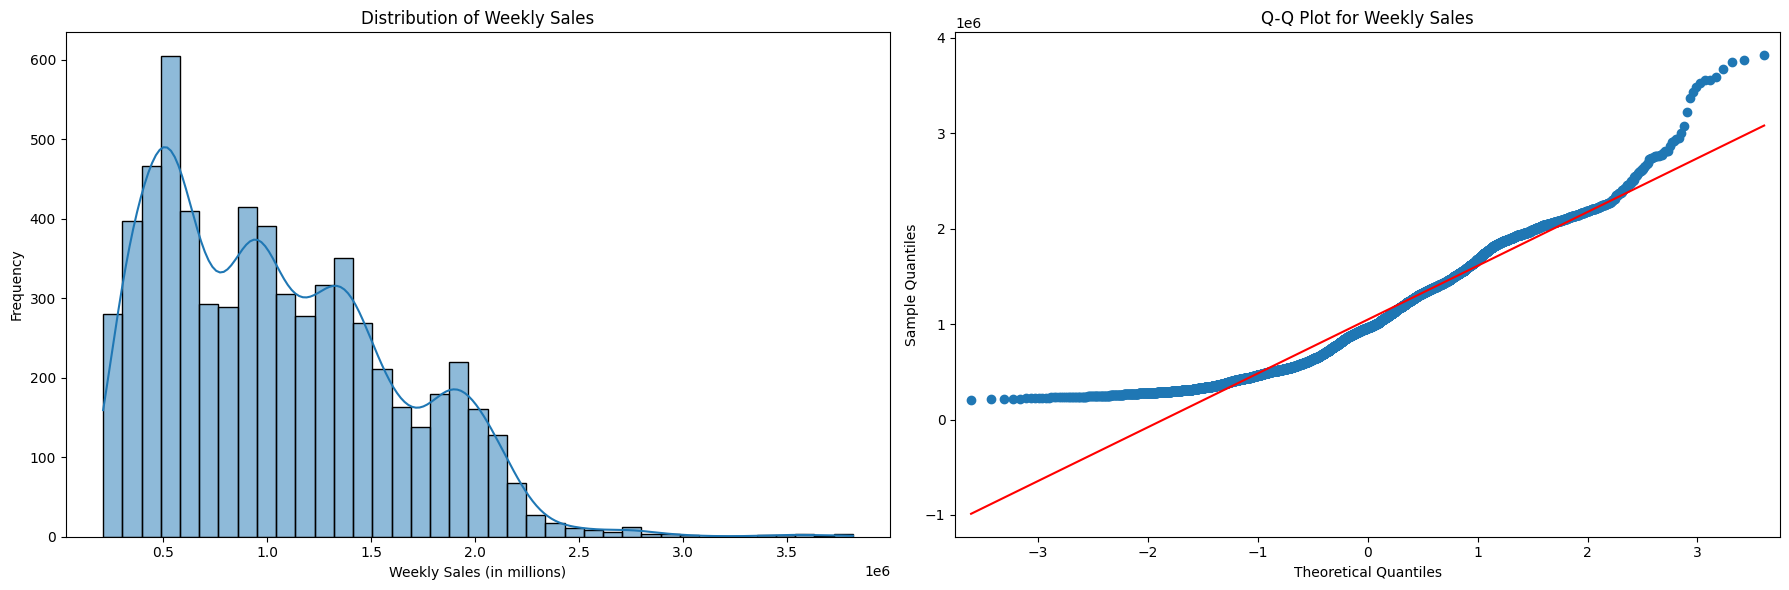

Shapiro-Wilk Test: Statistic = 0.9470728301310753, P-value = 3.822133481001218e-43
Reject the null hypothesis: Weekly sales are not normally distributed.


In [ ]:
# Creating a figure with two subplots 
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# Histogram
sns.histplot(walmart['Weekly_Sales'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Weekly Sales')
axes[0].set_xlabel('Weekly Sales (in millions)')
axes[0].set_ylabel('Frequency')

# Q-Q plot
sm.qqplot(walmart['Weekly_Sales'], line='s', ax=axes[1])
axes[1].set_title('Q-Q Plot for Weekly Sales')


plt.tight_layout()
plt.show()

# Shapiro-Wilk test
shapiro_stat, shapiro_p = shapiro(walmart['Weekly_Sales'])
print(f"Shapiro-Wilk Test: Statistic = {shapiro_stat}, P-value = {shapiro_p}")

# Interpreting results
alpha = 0.05
if shapiro_p > alpha:
    print("Fail to reject the null hypothesis: Weekly sales are normally distributed.")
else:
    print("Reject the null hypothesis: Weekly sales are not normally distributed.")

**The Shapiro-Wilk test and visualizations (histogram and Q-Q plot) indicated that the `raw data is not normally distributed.`**

In [ ]:
# Checking sample size
sample_size = len(walmart)
print(f"Sample Size: {sample_size}")

Sample Size: 6435


**However, with a sample size of `approximately 6370`, we can rely on the `Central Limit Theorem (CLT)`. The CLT states that the sampling distribution of the mean will be approximately normal, even if the raw data is not normally distributed. This allows us to perform parametric hypothesis tests (e.g., t-test)and calculate confidence intervals using the sample means. Alternatively, we could transform the data (e.g., using a log transformation) to make it morenormally distributed, but with such a large sample size, the CLT is sufficient.**

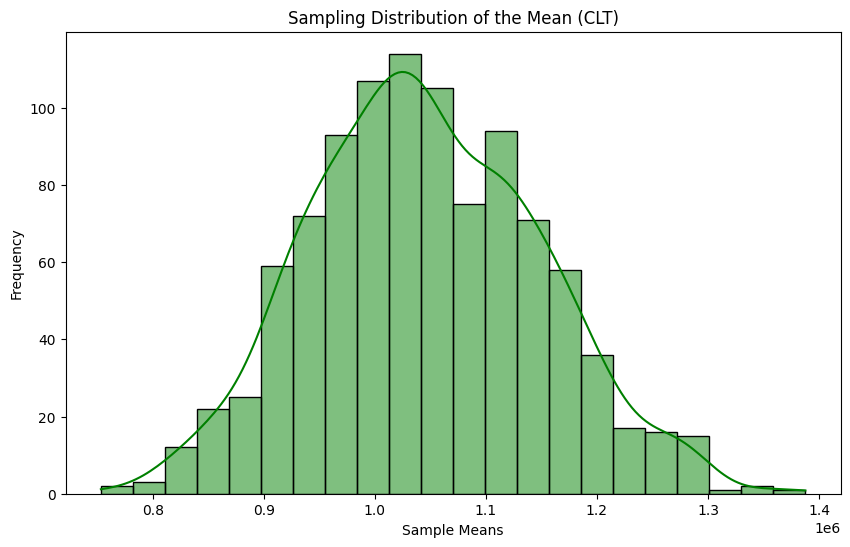

In [ ]:
# Simulate sampling distribution of the mean
sample_means = [np.mean(np.random.choice(walmart['Weekly_Sales'], size=30)) for _ in range(1000)]

plt.figure(figsize=(10, 6))
sns.histplot(sample_means, kde=True, color='green')
plt.title('Sampling Distribution of the Mean (CLT)')
plt.xlabel('Sample Means')
plt.ylabel('Frequency')
plt.show()

**- The bars in the histogram represent the frequency distribution of sample means. <br>- This means that for a large number of random samples taken from the population, the bars show how often each mean value occurs.<br>- The smooth curve overlaid on the histogram represents a normal distribution, which is fitted to the sample means.<br>- This curve demonstrates that the distribution of sample means approximates a bell-shaped, normal distribution, as predicted by the Central Limit Theorem (CLT).**<br>

**-----------------------------------------------------------------------------------------------------**

## **Question**
***"Do holidays significantly impact Walmart's weekly sales?"***

- Understanding the impact of holidays on sales helps Walmart plan inventory, staffing, and marketing strategies for holiday seasons.
- This question can be answered using hypothesis testing (to determine if the impact is statistically significant).

### ***Hypotheses:***

Null Hypothesis (H₀): No significant difference in mean sales between holidays and non-holidays.

Alternative Hypothesis (H₁): Significant difference in mean sales between holidays and non-holidays.

In [ ]:
# Split data into holiday and non-holiday sales
holiday_sales = walmart[walmart['Holiday_Season'] == 1]['Weekly_Sales']
non_holiday_sales = walmart[walmart['Holiday_Season'] == 0]['Weekly_Sales']

# Perform t-test
t_stat, p_value = ttest_ind(holiday_sales, non_holiday_sales)
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Holidays significantly impact weekly sales.")
else:
    print("Fail to reject the null hypothesis: Holidays do not significantly impact weekly sales.")

T-statistic: 9.508710777205815
P-value: 2.662914650967252e-21
Reject the null hypothesis: Holidays significantly impact weekly sales.


### **Insights**

**Conclusion (Statistical Interpretation)**

- The T-statistic is 9.51, and the P-value is extremely small (2.66e-21), which is well below the significance level of 0.05. Therefore, we reject the null hypothesis and conclude that holidays do significantly impact Walmart's weekly sales.

**Business Insights**

- The data suggests a substantial increase in sales during holidays. This could be due to higher consumer spending during the holiday season, driven by gift shopping, promotions, and special offers.
- Walmart should anticipate increased demand during holidays and stock up on popular products.
- With higher sales volumes, additional staff might be required to handle the surge in customers.
- Walmart can design special promotions and targeted campaigns around holidays to maximize sales.

`Holidays have a statistically significant impact on Walmart’s weekly sales. This insight allows Walmart to better plan for inventory, staffing, and marketing efforts during the holiday season to capitalize on the increased consumer spending.`

**-----------------------------------------------------------------------------------------------------**

## **Question**

***"Does the ambient temperature have a significant effect on Walmart’s weekly sales?"***

- Helps Walmart optimize inventory, staffing, and marketing based on temperature-driven sales trends.<br>
- Ensures decisions are backed by statistical evidence rather than assumptions.<br>
- The 95% confidence interval quantifies the true difference in sales between cold and hot conditions.<br>



### **Confidence interval**
**At First, I am Extracting Relevant Data:** by Isolating weekly sales for "Cold" and "Hot" temperature bins to use it in CI.

In [ ]:
try:
    cold_sales = walmart[walmart['Temperature_Bin'] == 'Cold']['Weekly_Sales']
    hot_sales = walmart[walmart['Temperature_Bin'] == 'Hot']['Weekly_Sales']
    
    if cold_sales.empty or hot_sales.empty:
        raise ValueError("Insufficient data: One or both temperature groups have no sales records.")
    
    print("Data successfully retrieved for both Cold and Hot temperature groups.")

except KeyError as e:
    print(f"KeyError: Column not found in dataset - {e}")
except ValueError as e:
    print(f"ValueError: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")


Data successfully retrieved for both Cold and Hot temperature groups.


#### Now we can perform a CI 

In [ ]:
try:
    # Mean and standard error of the difference
    mean_diff = np.mean(cold_sales) - np.mean(hot_sales)
    se = np.sqrt((np.var(cold_sales, ddof=1) / len(cold_sales)) + (np.var(hot_sales, ddof=1) / len(hot_sales)))
    
    # Compute the 95% confidence interval
    ci_lower, ci_upper = mean_diff - stats.t.ppf(0.975, df=len(cold_sales) + len(hot_sales) - 2) * se, \
                         mean_diff + stats.t.ppf(0.975, df=len(cold_sales) + len(hot_sales) - 2) * se

    print(f"95% Confidence Interval for Mean Difference: ({ci_lower:.2f}, {ci_upper:.2f})")

except ZeroDivisionError as e:
    print(f"ZeroDivisionError: Division by zero occurred - {e}")
except ValueError as e:
    print(f"ValueError: Invalid value encountered - {e}")
except TypeError as e:
    print(f"TypeError: Data type issue - {e}")
except Exception as e:
    print(f"Unexpected error: {e}")


95% Confidence Interval for Mean Difference: (33170.74, 117785.84)


### **Insights**

**Conclusion (Statistical Interpretation)**
- The 95% Confidence Interval for the difference in mean weekly sales between "Cold" and "Hot" conditions is (33,170.74, 117,785.84).<br> 
- Since the interval is entirely positive, we conclude that cold weather significantly increases weekly sales compared to hot weather.

**Business Insights**
- Cold weather boosts consumer demand, likely for winter-related goods.
- Increase stock during colder months to meet higher demand.
- Consider promotions during hot weather to boost sales.
- Ensure additional staffing and logistical support in cold weather.

`Cold weather leads to significantly higher sales at Walmart, providing valuable insights for optimizing inventory, marketing, and staffing strategies.`

**-----------------------------------------------------------------------------------------------------**

## **Predictive Analysis, Machine Learning (ML)**

#### **Objective:**
 ***1 .Can we predict Walmart's weekly sales accurately using the available features?.<br> 2.Which features are most important in influencing weekly sales?<br><br>***
 
 -The goal of this analysis is to predict Walmart's weekly sales using historical data and identify key factors influencing sales. <br>-We applied a `Random Forest Regressor` to build the predictive model

In [ ]:
# Feature 
features = ['Year', 'Month', 'Week', 'DayOfWeek', 'Holiday_Season', 'CPI', 'Unemployment', 'Fuel_Price', 'Prev_Week_Sales', 'Temperature_Bin']

X = pd.get_dummies(walmart[features], drop_first=True)  # One-hot encoding for categorical variables
y = walmart['Weekly_Sales']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}, R²: {r2}\n\n")

# Feature Importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

MSE: 9948232726.122517, R²: 0.9691196903032153


                     Feature  Importance
8            Prev_Week_Sales    0.924498
2                       Week    0.046741
7                 Fuel_Price    0.008126
5                        CPI    0.007580
6               Unemployment    0.007002
1                      Month    0.003901
0                       Year    0.001055
9   Temperature_Bin_Moderate    0.000724
10       Temperature_Bin_Hot    0.000219
4             Holiday_Season    0.000155
3                  DayOfWeek    0.000000


### **Results**
Top Features:

 - `Prev_Week_Sales` (92.45%)

- `Week` (4.67%)

- `Fuel_Price` (0.81%)

- Holiday_Season: The low importance of `Holiday_Season` suggests that holidays may not be as impactful as initially thought. However, this could be due to the dominance of `Prev_Week_Sales`.

### **Insights**

- ##### ***`Prev_Week_Sales` was the most important feature, indicating strong temporal dependency.***
- ##### ***We will `re-evalute` , `(Holiday_Season)` by performing feature enginnering and multiplying the `Prev_Week_Sales` and `Holiday_Season`***     

**-----------------------------------------------------------------------------------------------------**

### **Performing Feature Engineering**
- To capture the combined effect of holidays and previous week sales, we created an interaction term: `Holiday_PrevWeekSales`.

- This helps the model understand how holidays amplify the impact of previous week sales

In [ ]:
try:
    # Createing interaction term: Holiday_PrevWeekSales
    walmart['Holiday_PrevWeekSales'] = walmart['Holiday_Season'] * walmart['Prev_Week_Sales']
    print("Interaction term 'Holiday_PrevWeekSales' created successfully!")
    
except KeyError as e:
    print(f"KeyError: {e} - Ensure 'Holiday_Season' and 'Prev_Week_Sales' columns exist in the dataset.")
    
except TypeError as e:
    print(f"TypeError: {e} - Ensure 'Holiday_Season' and 'Prev_Week_Sales' contain numeric data.")
    
except Exception as e:
    print(f"Unexpected error while creating interaction term: {e}")

Interaction term 'Holiday_PrevWeekSales' created successfully!


In [ ]:
features = ['Year', 'Month', 'Week', 'DayOfWeek', 'Holiday_Season', 'CPI', 'Unemployment', 'Fuel_Price', 'Prev_Week_Sales', 'Temperature_Bin', 'Holiday_PrevWeekSales']
X = pd.get_dummies(walmart[features], drop_first=True)  # One-hot encoding for categorical variables
y = walmart['Weekly_Sales']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}, R²: {r2}\n\n\n")

# Feature Importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

MSE: 10330358969.899837, R²: 0.967933532211022



                     Feature  Importance
8            Prev_Week_Sales    0.919382
2                       Week    0.044108
7                 Fuel_Price    0.008234
9      Holiday_PrevWeekSales    0.008193
5                        CPI    0.007931
6               Unemployment    0.006817
1                      Month    0.003300
0                       Year    0.001034
10  Temperature_Bin_Moderate    0.000683
11       Temperature_Bin_Hot    0.000221
4             Holiday_Season    0.000096
3                  DayOfWeek    0.000000


### Results
- **R²**: 0.9679  
- **MSE**: 10,330,358,969.90  

### Top Features
1. **Prev_Week_Sales**: 91.94%  
2. **Week**: 4.41%  
3. **Fuel_Price**: 0.82%  
4. **Holiday_PrevWeekSales**: 0.82%  

### Insights
- The interaction term (**Holiday_PrevWeekSales**) became the fourth most important feature, showing that **holidays amplify the impact of previous week sales**.  
- The model’s performance remained **strong**, with:
  - A slight decrease in **R²**.  
  - A small increase in **MSE**, which is negligible given the high **R²** score.


**-----------------------------------------------------------------------------------------------------**

## Comparison of Both Models

| **Metric**          | **Without Interaction Term** | **With Interaction Term** |
|----------------------|------------------------------|----------------------------|
| **R² Score**         | 0.9691                       | 0.9679                     |
| **MSE**              | 9,948,232,726.12            | 10,330,358,969.90          |
| **Top Features**     |                              |                            |
| - Prev_Week_Sales    | 92.45%                       | 91.94%                     |
| - Week               | 4.67%                        | 4.41%                      |
| - Fuel_Price         | 0.81%                        | 0.82%                      |
| - Holiday_PrevWeekSales | N/A                        | 0.82%                      |


**-----------------------------------------------------------------------------------------------------**

## Key Insights and Patterns from the Analysis

### 1. Key Factors Influencing Weekly Sales
- **Prev_Week_Sales**: Most significant factor (91.94%), showing strong temporal dependency.
- **Week**: Second most important feature (4.41%), indicating weekly seasonality.
- **Fuel_Price**: Minor but measurable impact (0.82%).
- **Holiday_PrevWeekSales**: Holidays amplify the impact of previous week sales (0.82%).

### 2. Impact of Holidays on Sales
- **Statistical Significance**: Holidays significantly impact sales (p-value < 0.05).
- **Sales Increase**: Notable spikes in sales during holidays (e.g., November, December).
- **Business Implication**: Increase inventory, staffing, and targeted marketing during holidays to maximize revenue.

### Impact of Temperature on Sales
- **Cold Weather**: Higher sales during colder months (confidence interval: 33,170.74 to 117,785.84).
- **Business Implication**: Stock winter-related goods for colder months; use promotions in hot weather.

### 3. Seasonal Trends and Patterns
- **Holiday Season**: Peaks during November and December due to holidays like Thanksgiving and Christmas.
- **Weekly Trends**: Consistent weekly sales patterns, with holiday weeks driving higher sales.
- **Temperature Trends**: Higher sales in colder months, lower in hotter months.

### 4. External Factors (CPI, Unemployment, Fuel Prices)
- **CPI and Unemployment**: Weak correlations with sales, minimal direct impact.
- **Fuel Prices**: Minor influence on sales, not a dominant factor.

### 5. Yes we can Predictive Model Performance
- **Model**: Random Forest Regressor
- **Performance**:
  - **R² Score**: 0.9679 (with interaction term), explaining 96.79% of the variance.
  - **MSE**: 10,330,358,969.90, relatively low given Walmart's sales scale.
- **Top Features**:
  - Prev_Week_Sales: 91.94%
  - Week: 4.41%
  - Fuel_Price: 0.82%
  - Holiday_PrevWeekSales: 0.82%

### 6. Analysis During Festive Weeks 
- Sales during festive weeks show a significant increase, with **Christmas week** having the highest surge. 
- This indicates heightened consumer activity and emphasizes the importance of these periods for targeted promotions and inventory management.
---

## Conclusion 
- The analysis reveals that temporal factors (previous week sales and weekly trends) and seasonal factors (holidays and temperature) are the most significant drivers of Walmart's weekly sales. By focusing on these areas, Walmart can optimize its operations, improve inventory management, and enhance customer satisfaction during peak seasons
